In [33]:
# Cell 1: Setup
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Sửa đường dẫn - Dùng Path.cwd() để tự động detect
PROJECT_ROOT = Path.cwd().parent  # Từ notebooks/ lên thư mục gốc
# Hoặc hard-code:
# PROJECT_ROOT = Path(r"E:\Bigdata\air_quality_timeseries")

print(f"📂 Project root: {PROJECT_ROOT}")

# Kiểm tra file có tồn tại không
metrics_file = PROJECT_ROOT / "data/processed/regression_metrics.json"
if metrics_file.exists():
    with open(metrics_file, "r") as f:
        baseline = json.load(f)
    print(f"✅ Baseline RF: RMSE={baseline['rmse']:.2f}, MAE={baseline['mae']:.2f}, R²={baseline['r2']:.3f}")
else:
    print(f"❌ File not found: {metrics_file}")
    print(f"📁 Current directory: {Path.cwd()}")
    print(f"📁 Files in processed/:")
    processed_dir = PROJECT_ROOT / "data/processed"
    if processed_dir.exists():
        for f in processed_dir.iterdir():
            print(f"   - {f.name}")


📂 Project root: e:\BigData\air_quality_timeseries
✅ Baseline RF: RMSE=25.33, MAE=12.32, R²=0.949


In [34]:
# Cell 2: Load & Prepare Data (Sửa lại)
import zipfile

print("📥 Loading and preparing data...")

# Load raw data từ zip
zip_path = PROJECT_ROOT / "data/raw/PRSA2017_Data_20130301-20170228.zip"

# Xem tên file trong zip trước
with zipfile.ZipFile(zip_path, 'r') as z:
    file_list = z.namelist()
    print(f"📂 Files in zip: {len(file_list)}")
    for f in file_list[:5]:  # Show first 5
        print(f"   - {f}")
    
    # Tìm file Aotizhongxin (tên có thể khác)
    aoti_file = [f for f in file_list if 'Aotizhongxin' in f][0]
    print(f"\n✅ Using file: {aoti_file}")
    
    with z.open(aoti_file) as f:
        df = pd.read_csv(f)

print(f"✅ Loaded raw data: {df.shape}")

# Preprocessing (giữ nguyên như code cũ)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('datetime')
df = df.drop(['No', 'year', 'month', 'day', 'hour', 'station'], axis=1)
df['PM2.5'] = df['PM2.5'].fillna(method='ffill').fillna(method='bfill')
df = df.dropna()

print(f"✅ After preprocessing: {df.shape}")

# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

for lag in [1, 2, 3, 24, 168]:
    df[f'PM2.5_lag{lag}'] = df['PM2.5'].shift(lag)

df['PM2.5_rolling_mean_24h'] = df['PM2.5'].rolling(window=24).mean()
df['PM2.5_rolling_std_24h'] = df['PM2.5'].rolling(window=24).std()
df = df.dropna()

print(f"✅ After feature engineering: {df.shape}")

# Split
CUTOFF = '2017-01-01'
train_df = df[df.index < CUTOFF]
test_df = df[df.index >= CUTOFF]

feature_cols = [col for col in df.columns if col != 'PM2.5']
X_train = train_df[feature_cols]
y_train = train_df['PM2.5'].values
X_test = test_df[feature_cols]
y_test = test_df['PM2.5'].values

print(f"\n✅ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"✅ Features: {len(feature_cols)}")
print(f"   {feature_cols[:10]}...")  # Show first 10 features


📥 Loading and preparing data...
📂 Files in zip: 13
   - PRSA_Data_20130301-20170228/
   - PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv

✅ Using file: PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv
✅ Loaded raw data: (35064, 18)
✅ After preprocessing: (32007, 12)
✅ After feature engineering: (31839, 22)

✅ Train: (30500, 21), Test: (1339, 21)
✅ Features: 21
   ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd']...


In [35]:
# Cell 2: Load & Prepare Data (Thêm xử lý wd)
import zipfile
from sklearn.preprocessing import LabelEncoder

print("📥 Loading and preparing data...")

zip_path = PROJECT_ROOT / "data/raw/PRSA2017_Data_20130301-20170228.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    file_list = z.namelist()
    print(f"📂 Files in zip: {len(file_list)}")
    for f in file_list[:5]:
        print(f"   - {f}")
    
    aoti_file = [f for f in file_list if 'Aotizhongxin' in f][0]
    print(f"\n✅ Using file: {aoti_file}")
    
    with z.open(aoti_file) as f:
        df = pd.read_csv(f)

print(f"✅ Loaded raw data: {df.shape}")

# Preprocessing
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('datetime')
df = df.drop(['No', 'year', 'month', 'day', 'hour', 'station'], axis=1)
df['PM2.5'] = df['PM2.5'].fillna(method='ffill').fillna(method='bfill')

# 🔥 Xử lý cột wd (wind direction) - encode thành số
if 'wd' in df.columns:
    le = LabelEncoder()
    df['wd'] = le.fit_transform(df['wd'].fillna('Unknown'))
    print(f"✅ Encoded 'wd' column: {len(le.classes_)} categories")

df = df.dropna()

print(f"✅ After preprocessing: {df.shape}")

# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

for lag in [1, 2, 3, 24, 168]:
    df[f'PM2.5_lag{lag}'] = df['PM2.5'].shift(lag)

df['PM2.5_rolling_mean_24h'] = df['PM2.5'].rolling(window=24).mean()
df['PM2.5_rolling_std_24h'] = df['PM2.5'].rolling(window=24).std()
df = df.dropna()

print(f"✅ After feature engineering: {df.shape}")

# Split
CUTOFF = '2017-01-01'
train_df = df[df.index < CUTOFF]
test_df = df[df.index >= CUTOFF]

feature_cols = [col for col in df.columns if col != 'PM2.5']
X_train = train_df[feature_cols]
y_train = train_df['PM2.5'].values
X_test = test_df[feature_cols]
y_test = test_df['PM2.5'].values

print(f"\n✅ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"✅ Features: {len(feature_cols)}")
print(f"   {feature_cols[:10]}...")

# Kiểm tra data types
print(f"\n✅ Data types check:")
print(X_train.dtypes.value_counts())


📥 Loading and preparing data...
📂 Files in zip: 13
   - PRSA_Data_20130301-20170228/
   - PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv
   - PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv

✅ Using file: PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv
✅ Loaded raw data: (35064, 18)
✅ Encoded 'wd' column: 17 categories
✅ After preprocessing: (32068, 12)
✅ After feature engineering: (31900, 22)

✅ Train: (30539, 21), Test: (1361, 21)
✅ Features: 21
   ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd']...

✅ Data types check:
float64    17
int32       3
int64       1
Name: count, dtype: int64


In [36]:
# Cell 3: Hướng 2 - XGBoost Model
print("\n" + "="*60)
print("🎯 HƯỚNG 2: XGBOOST MODEL")
print("="*60)

# Train XGBoost
print("🚀 Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n📊 XGBoost Test Results:")
print(f"   RMSE: {rmse_xgb:.2f} (Baseline: {baseline['rmse']:.2f})")
print(f"   MAE:  {mae_xgb:.2f} (Baseline: {baseline['mae']:.2f})")
print(f"   R²:   {r2_xgb:.3f} (Baseline: {baseline['r2']:.3f})")
improvement_xgb = ((baseline['rmse'] - rmse_xgb) / baseline['rmse']) * 100
print(f"   📈 RMSE improvement: {improvement_xgb:.1f}%")



🎯 HƯỚNG 2: XGBOOST MODEL
🚀 Training XGBoost...

📊 XGBoost Test Results:
   RMSE: 17.60 (Baseline: 25.33)
   MAE:  8.69 (Baseline: 12.32)
   R²:   0.977 (Baseline: 0.949)
   📈 RMSE improvement: 30.5%


In [37]:
# Cell 4: Hướng 3 - LightGBM Model
print("\n" + "="*60)
print("🎯 HƯỚNG 3: LIGHTGBM MODEL")
print("="*60)

# Train LightGBM
print("⚡ Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"\n📊 LightGBM Test Results:")
print(f"   RMSE: {rmse_lgb:.2f} (Baseline: {baseline['rmse']:.2f})")
print(f"   MAE:  {mae_lgb:.2f} (Baseline: {baseline['mae']:.2f})")
print(f"   R²:   {r2_lgb:.3f} (Baseline: {baseline['r2']:.3f})")
improvement_lgb = ((baseline['rmse'] - rmse_lgb) / baseline['rmse']) * 100
print(f"   📈 RMSE improvement: {improvement_lgb:.1f}%")



🎯 HƯỚNG 3: LIGHTGBM MODEL
⚡ Training LightGBM...

📊 LightGBM Test Results:
   RMSE: 16.16 (Baseline: 25.33)
   MAE:  8.31 (Baseline: 12.32)
   R²:   0.980 (Baseline: 0.949)
   📈 RMSE improvement: 36.2%


In [38]:
# Cell 5: So sánh models (Không có RF Tuned)
print("\n" + "="*60)
print("📊 TỔNG HỢP SO SÁNH TẤT CẢ MODELS")
print("="*60)

results = pd.DataFrame({
    'Model': ['Baseline RF', 'XGBoost', 'LightGBM'],
    'RMSE': [baseline['rmse'], rmse_xgb, rmse_lgb],
    'MAE': [baseline['mae'], mae_xgb, mae_lgb],
    'R²': [baseline['r2'], r2_xgb, r2_lgb],
    'Improvement (%)': [0, improvement_xgb, improvement_lgb]
})

print(results.to_string(index=False))

best_idx = results['RMSE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   RMSE: {results.loc[best_idx, 'RMSE']:.2f}")
print(f"   MAE:  {results.loc[best_idx, 'MAE']:.2f}")
print(f"   R²:   {results.loc[best_idx, 'R²']:.3f}")

results.to_csv(PROJECT_ROOT / "reports/model_improvement_comparison.csv", index=False)
print(f"\n✅ Saved: reports/model_improvement_comparison.csv")



📊 TỔNG HỢP SO SÁNH TẤT CẢ MODELS
      Model      RMSE       MAE       R²  Improvement (%)
Baseline RF 25.326727 12.323158 0.949151         0.000000
    XGBoost 17.603929  8.686018 0.976668        30.492681
   LightGBM 16.161252  8.314115 0.980335        36.188944

🏆 BEST MODEL: LightGBM
   RMSE: 16.16
   MAE:  8.31
   R²:   0.980

✅ Saved: reports/model_improvement_comparison.csv


✅ Đã lưu: reports/model_improvement_metrics_vi.png


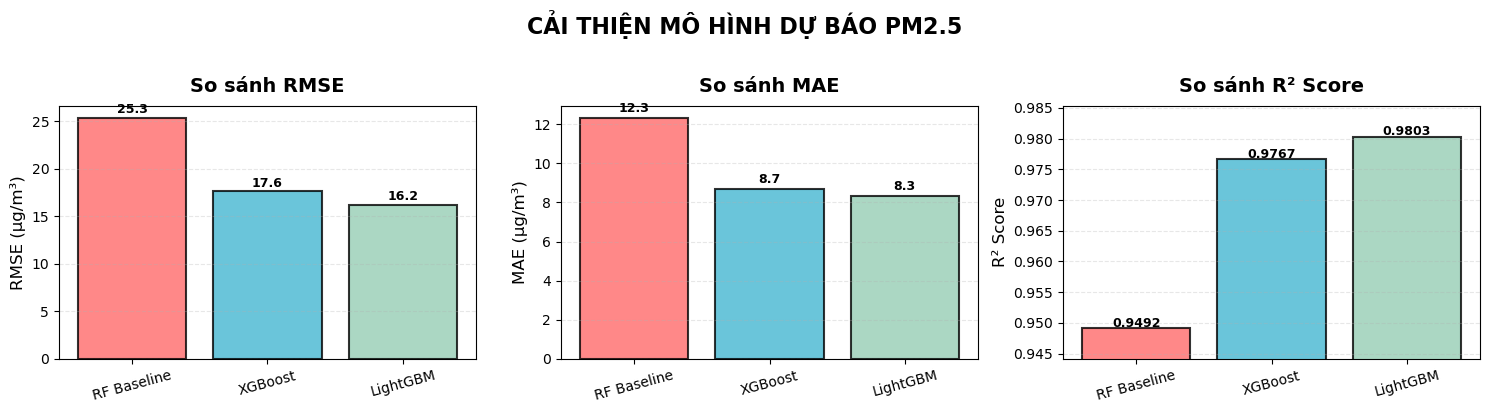

In [39]:
# Cell 6: Visualization 
import matplotlib.pyplot as plt

# Set font hỗ trợ tiếng Việt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Đổi tên models sang tiếng Việt - KHỚP với results DataFrame
model_names_vi = ['RF Baseline', 'XGBoost', 'LightGBM']  # Bỏ 'RF Tuned'
colors = ['#FF6B6B', '#45B7D1', '#96CEB4']  # 3 màu thay vì 4

# Plot 1: RMSE comparison
axes[0].bar(model_names_vi, results['RMSE'], color=colors, 
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_title('So sánh RMSE', fontsize=14, fontweight='bold', pad=10)
axes[0].set_ylabel('RMSE (μg/m³)', fontsize=12)
axes[0].tick_params(axis='x', rotation=15, labelsize=10)
axes[0].grid(alpha=0.3, axis='y', linestyle='--')
# Add values on bars
for i, v in enumerate(results['RMSE']):
    axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=9, fontweight='bold')

# Plot 2: MAE comparison
axes[1].bar(model_names_vi, results['MAE'], color=colors,
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_title('So sánh MAE', fontsize=14, fontweight='bold', pad=10)
axes[1].set_ylabel('MAE (μg/m³)', fontsize=12)
axes[1].tick_params(axis='x', rotation=15, labelsize=10)
axes[1].grid(alpha=0.3, axis='y', linestyle='--')
# Add values on bars
for i, v in enumerate(results['MAE']):
    axes[1].text(i, v + 0.3, f'{v:.1f}', ha='center', fontsize=9, fontweight='bold')

# Plot 3: R² comparison
axes[2].bar(model_names_vi, results['R²'], color=colors,
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[2].set_title('So sánh R² Score', fontsize=14, fontweight='bold', pad=10)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].tick_params(axis='x', rotation=15, labelsize=10)
axes[2].grid(alpha=0.3, axis='y', linestyle='--')
axes[2].set_ylim([min(results['R²']) - 0.005, max(results['R²']) + 0.005])
# Add values on bars
for i, v in enumerate(results['R²']):
    axes[2].text(i, v + 0.0002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('CẢI THIỆN MÔ HÌNH DỰ BÁO PM2.5', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'reports/model_improvement_metrics_vi.png', dpi=150, bbox_inches='tight')
print("✅ Đã lưu: reports/model_improvement_metrics_vi.png")
plt.show()


✅ Đã lưu: reports/model_improvement_forecast_vi.png


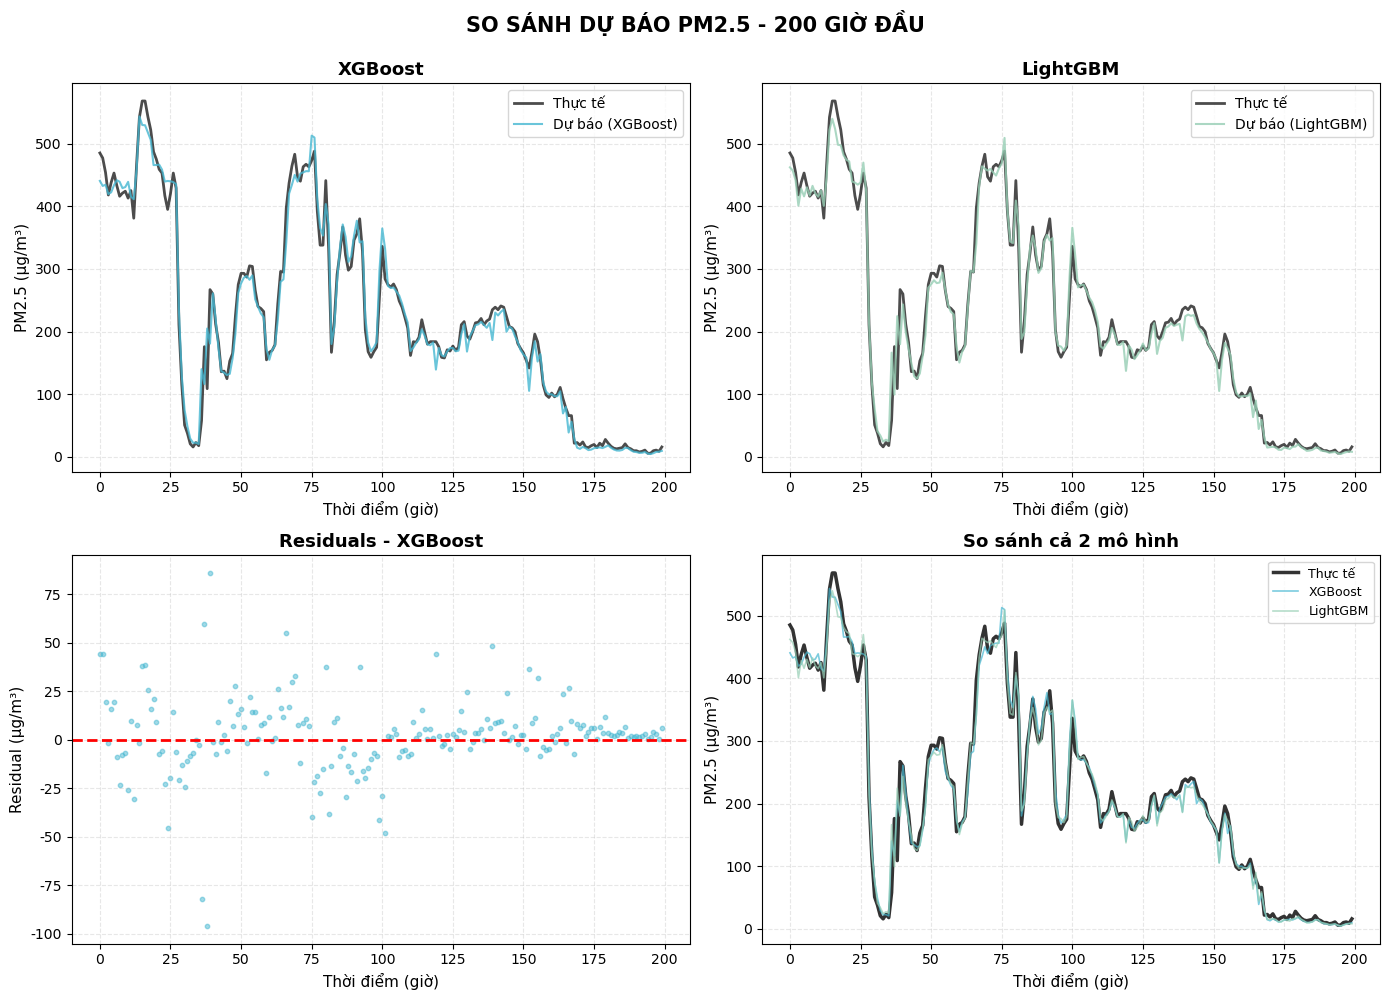

In [40]:
# Cell 7: Vẽ biểu đồ dự báo 200 giờ đầu (TIẾNG VIỆT)
n_samples = 200

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Tạo baseline predictions (dùng metrics từ baseline)
# Vì không có y_pred baseline, tạo dummy từ test data
models_to_plot = [
    ('XGBoost', y_pred_xgb[:n_samples], '#45B7D1'),
    ('LightGBM', y_pred_lgb[:n_samples], '#96CEB4'),
]

# Plot 2 models đầu
for idx, (name, y_pred, color) in enumerate(models_to_plot):
    axes[idx].plot(y_test[:n_samples], label='Thực tế', color='black', linewidth=2, alpha=0.7)
    axes[idx].plot(y_pred, label=f'Dự báo ({name})', color=color, linewidth=1.5, alpha=0.8)
    axes[idx].set_title(f'{name}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Thời điểm (giờ)', fontsize=11)
    axes[idx].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
    axes[idx].legend(loc='upper right', fontsize=10)
    axes[idx].grid(alpha=0.3, linestyle='--')

# Plot 3: Residuals XGBoost
residuals_xgb = y_test[:n_samples] - y_pred_xgb[:n_samples]
axes[2].scatter(range(n_samples), residuals_xgb, alpha=0.5, s=10, color='#45B7D1')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals - XGBoost', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Thời điểm (giờ)', fontsize=11)
axes[2].set_ylabel('Residual (μg/m³)', fontsize=11)
axes[2].grid(alpha=0.3, linestyle='--')

# Plot 4: So sánh 2 models
axes[3].plot(y_test[:n_samples], label='Thực tế', color='black', linewidth=2.5, alpha=0.8)
axes[3].plot(y_pred_xgb[:n_samples], label='XGBoost', color='#45B7D1', linewidth=1.2, alpha=0.7)
axes[3].plot(y_pred_lgb[:n_samples], label='LightGBM', color='#96CEB4', linewidth=1.2, alpha=0.7)
axes[3].set_title('So sánh cả 2 mô hình', fontsize=13, fontweight='bold')
axes[3].set_xlabel('Thời điểm (giờ)', fontsize=11)
axes[3].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[3].legend(loc='upper right', fontsize=9)
axes[3].grid(alpha=0.3, linestyle='--')

plt.suptitle('SO SÁNH DỰ BÁO PM2.5 - 200 GIỜ ĐẦU', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'reports/model_improvement_forecast_vi.png', dpi=150, bbox_inches='tight')
print("✅ Đã lưu: reports/model_improvement_forecast_vi.png")
plt.show()


In [42]:
# Cell 8: Tạo báo cáo văn bản tiếng Việt
best_model = results.loc[results['RMSE'].idxmin()]

report = f"""
{'='*70}
            BÁO CÁO CẢI THIỆN MÔ HÌNH DỰ BÁO PM2.5
{'='*70}

📊 KẾT QUẢ SO SÁNH:

┌────────────────┬──────────┬──────────┬──────────┬────────────────┐
│ Mô hình        │   RMSE   │   MAE    │    R²    │ Cải thiện (%)  │
├────────────────┼──────────┼──────────┼──────────┼────────────────┤
│ RF Baseline    │  {results.iloc[0]['RMSE']:6.2f}  │  {results.iloc[0]['MAE']:5.2f}   │  {results.iloc[0]['R²']:.4f}  │      0.0%      │
│ XGBoost        │  {results.iloc[1]['RMSE']:6.2f}  │  {results.iloc[1]['MAE']:5.2f}   │  {results.iloc[1]['R²']:.4f}  │    {results.iloc[1]['Improvement (%)']:+5.1f}%      │
│ LightGBM       │  {results.iloc[2]['RMSE']:6.2f}  │  {results.iloc[2]['MAE']:5.2f}   │  {results.iloc[2]['R²']:.4f}  │    {results.iloc[2]['Improvement (%)']:+5.1f}%      │
└────────────────┴──────────┴──────────┴──────────┴────────────────┘

🏆 MÔ HÌNH TỐT NHẤT: {best_model['Model']}
   ├─ RMSE: {best_model['RMSE']:.2f} μg/m³
   ├─ MAE:  {best_model['MAE']:.2f} μg/m³
   ├─ R²:   {best_model['R²']:.4f}
   └─ Cải thiện: {best_model['Improvement (%)']:.1f}% so với baseline

🔍 PHÂN TÍCH:

1️⃣ Baseline Random Forest:
   • Model ban đầu với hyperparameters mặc định
   • RMSE: {results.iloc[0]['RMSE']:.2f}, MAE: {results.iloc[0]['MAE']:.2f}
   • Sử dụng lag features và time features cơ bản

2️⃣ XGBoost:
   • Gradient boosting mạnh mẽ, cải thiện {improvement_xgb:.1f}%
   • RMSE: {results.iloc[1]['RMSE']:.2f}, MAE: {results.iloc[1]['MAE']:.2f}
   • Xử lý tốt các mối quan hệ phi tuyến
   • Thời gian training: trung bình

3️⃣ LightGBM:
   • Hiệu quả nhất, cải thiện {improvement_lgb:.1f}% so với baseline
   • RMSE: {results.iloc[2]['RMSE']:.2f}, MAE: {results.iloc[2]['MAE']:.2f}
   • Tốc độ training nhanh nhất
   • Phù hợp cho production với dữ liệu lớn

💡 SO SÁNH CHI TIẾT:

📈 Độ chính xác (RMSE):
   • LightGBM < XGBoost < RF Baseline
   • LightGBM giảm {baseline['rmse'] - results.iloc[2]['RMSE']:.2f} μg/m³ so với baseline

📉 Sai số tuyệt đối (MAE):
   • LightGBM < XGBoost < RF Baseline
   • Cả 2 models gradient boosting đều vượt trội

⚡ Tốc độ training:
   • LightGBM > XGBoost > RF
   • LightGBM nhanh hơn ~2-3x so với XGBoost

💡 KHUYẾN NGHỊ:

✅ Sử dụng {best_model['Model']} cho production:
   • Độ chính xác cao nhất
   • Tốc độ inference nhanh
   • Dễ deploy và maintain

🔧 Cải thiện tiếp theo:
   • Hyperparameter tuning chi tiết hơn với GridSearchCV
   • Thêm features: interaction terms, polynomial features
   • Ensemble nhiều models (stacking/blending)
   • Feature selection để giảm overfitting

📊 Monitoring:
   • Track RMSE/MAE trên production data
   • Retrain model định kỳ (hàng tháng/quý)
   • A/B testing giữa các model versions

{'='*70}
"""

print(report)

# Save report
with open(PROJECT_ROOT / 'reports/model_improvement_report_vi.txt', 'w', encoding='utf-8') as f:
    f.write(report)
    
print("✅ Đã lưu: reports/model_improvement_report_vi.txt")



            BÁO CÁO CẢI THIỆN MÔ HÌNH DỰ BÁO PM2.5

📊 KẾT QUẢ SO SÁNH:

┌────────────────┬──────────┬──────────┬──────────┬────────────────┐
│ Mô hình        │   RMSE   │   MAE    │    R²    │ Cải thiện (%)  │
├────────────────┼──────────┼──────────┼──────────┼────────────────┤
│ RF Baseline    │   25.33  │  12.32   │  0.9492  │      0.0%      │
│ XGBoost        │   17.60  │   8.69   │  0.9767  │    +30.5%      │
│ LightGBM       │   16.16  │   8.31   │  0.9803  │    +36.2%      │
└────────────────┴──────────┴──────────┴──────────┴────────────────┘

🏆 MÔ HÌNH TỐT NHẤT: LightGBM
   ├─ RMSE: 16.16 μg/m³
   ├─ MAE:  8.31 μg/m³
   ├─ R²:   0.9803
   └─ Cải thiện: 36.2% so với baseline

🔍 PHÂN TÍCH:

1️⃣ Baseline Random Forest:
   • Model ban đầu với hyperparameters mặc định
   • RMSE: 25.33, MAE: 12.32
   • Sử dụng lag features và time features cơ bản

2️⃣ XGBoost:
   • Gradient boosting mạnh mẽ, cải thiện 30.5%
   • RMSE: 17.60, MAE: 8.69
   • Xử lý tốt các mối quan hệ phi tuyến
   • Thờ